# 🐥 Project 03: 가구 이미지 모델 분류
---
## 주제: 가구(미세 조정 fine_tune (유사도 높은 데이터세트 탐색))
---
### 목표 (Target)



### 목차
1. 데이터셋 불러오기.
2. 데이터 프레임으로 file 경로 및 target 분류.
3. fine_tuning을 통한 학습 시간의 효율적 확보.
4. 데이터 훈련.
5. 데이터 검증.
6. 결론.

## 1. 이미지 불러오기

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/p_furniture/'

IMAGE_SIZE = 128
BATCH_SIZE = 64

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
print(generator.class_indices)

Found 15000 images belonging to 5 classes.
{'almirah_dataset': 0, 'chair_dataset': 1, 'fridge dataset': 2, 'table dataset': 3, 'tv dataset': 4}


In [2]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'almirah_dataset',
 1: 'chair_dataset',
 2: 'fridge dataset',
 3: 'table dataset',
 4: 'tv dataset'}

In [3]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [4]:
import pandas as pd

f_df = pd.DataFrame({'file_paths': generator.filepaths,'target_names': target_names, 'targets': generator.classes})
f_df

,file_paths,target_names,targets
0,./datasets/p_furniture/almirah_dataset/image_1...,almirah_dataset,0
1,./datasets/p_furniture/almirah_dataset/image_1...,almirah_dataset,0
2,./datasets/p_furniture/almirah_dataset/image_1...,almirah_dataset,0
3,./datasets/p_furniture/almirah_dataset/image_1...,almirah_dataset,0
4,./datasets/p_furniture/almirah_dataset/image_1...,almirah_dataset,0
...,...,...,...
14995,./datasets/p_furniture/tv dataset/image_995.jpeg,tv dataset,4
14996,./datasets/p_furniture/tv dataset/image_996.jpeg,tv dataset,4
14997,./datasets/p_furniture/tv dataset/image_997.jpeg,tv dataset,4
14998,./datasets/p_furniture/tv dataset/image_998.jpeg,tv dataset,4


In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(f_df.file_paths, 
                 f_df.targets, 
                 stratify=f_df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
3    2400
0    2400
2    2400
1    2400
4    2400
Name: count, dtype: int64
targets
2    600
4    600
0    600
3    600
1    600
Name: count, dtype: int64


In [7]:
train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, train_targets, stratify = train_targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
2    1920
0    1920
1    1920
3    1920
4    1920
Name: count, dtype: int64
targets
3    480
0    480
1    480
4    480
2    480
Name: count, dtype: int64
targets
2    600
4    600
0    600
3    600
1    600
Name: count, dtype: int64


## 2. 데이터 프레임 분리

In [9]:
train_df = f_df.iloc[train_images.index].reset_index(drop=True)
validation_df = f_df.iloc[validation_images.index].reset_index(drop=True)
test_df = f_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(9600, 3)
(2400, 3)
(3000, 3)


## 3-0. 유사도를 확인하기 위해 사전 훈련 모델을 통한 이미지 데이터 확인
## 3-0-1. VGG 모델을 사용했을 때 차량 분류가 높은 사항으로 나와 유사도는 높다고 판단 후 추가 훈련 진행

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Image 1:
('n04239074', 'sliding_door', 0.9773481)
sliding_door 97.7348%


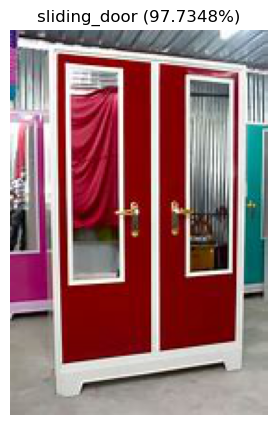



Image 2:
('n04590129', 'window_shade', 0.302527)
window_shade 30.2527%


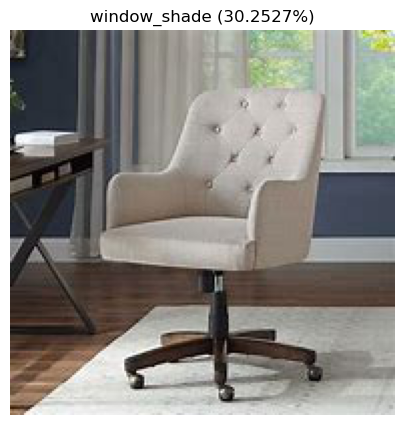



Image 3:
('n04550184', 'wardrobe', 0.6346494)
wardrobe 63.4649%


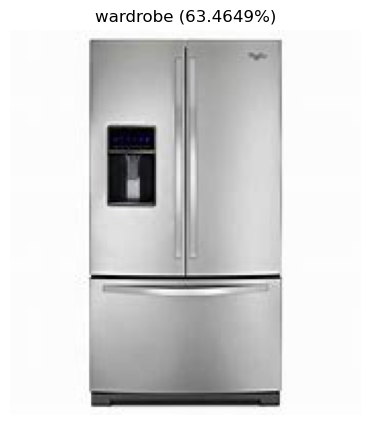



Image 4:
('n03201208', 'dining_table', 0.94068795)
dining_table 94.0688%


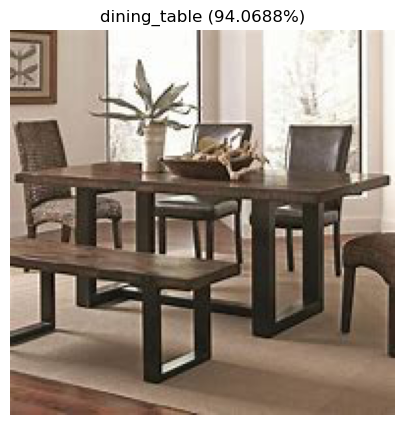



Image 5:
('n04404412', 'television', 0.80063295)
television 80.0633%


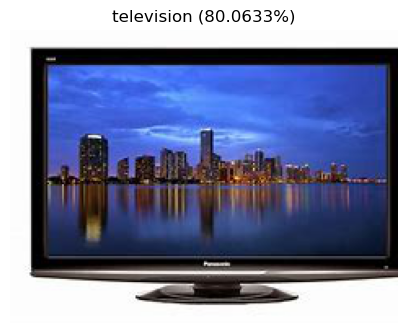

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions


# 모델을 로드합니다.
model = VGG16(weights='imagenet')

# 이미지를 로드하고 전처리하는 함수입니다.
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    image = load_img(img_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

# 이미지 출력 함수 선언
def show_image_with_prediction(image, prediction):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    title = f'{prediction[1]} ({np.round(float(prediction[2]) * 100, 4)}%)'
    plt.title(title)
    plt.show()

# 이미지 파일 경로 리스트를 정의합니다.
image_paths = [
    './datasets/p_furniture/almirah_dataset/image_1.jpeg',
    './datasets/p_furniture/chair_dataset/image_1.jpeg',
    './datasets/p_furniture/fridge dataset/image_1.jpeg',
    './datasets/p_furniture/table dataset/image_1.jpeg',
    './datasets/p_furniture/tv dataset/image_1.jpeg'
]

# 이미지를 로드하고 배열로 변환합니다.
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# 예측을 수행합니다.
predictions = model.predict(images)

# 예측 결과를 디코딩하고 출력합니다.
for i, img_path in enumerate(image_paths):
    # 원본 이미지를 로드하고 색상 변환
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    prediction = decode_predictions(np.expand_dims(predictions[i], axis=0))
    
    # 예측 결과 출력 및 이미지 표시
    print(f"Image {i + 1}:")
    print(prediction[0][0])
    print(prediction[0][0][1], f'{np.round(prediction[0][0][2] * 100, 4)}%')
    
    show_image_with_prediction(image, prediction[0][0])
    print("\n")


## 3-1. 이미지의 개수가 적기 때문에 데이터셋 미세조정 및 albumentation.
## 3-1-1.fine_tuning 을 통한 분류기만 훈련 진행

In [40]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 64
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    # batch_size 단위로 이미지 배열과 타켓 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)
                    
            results_batch[i] = image

        return results_batch, targets_batch
        
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)        

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [42]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 부분 freeze 진행
    # for layer in model.layers[:85]:
    #     layer.trainable = False
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [43]:
model = create_model()
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# freeze 확인하기
for i, layer in enumerate(model.layers[:-3]):
    layer.trainable = False
    print(i + 1, '.', layer.name, 'trainable:', layer.trainable)

print('\n######### classifier layers ######### ')
for layer in model.layers[-3:]:
    print(layer.name, 'trainable:', layer.trainable)

1 . input_layer_8 trainable: False
2 . block1_conv1 trainable: False
3 . block1_conv2 trainable: False
4 . block1_pool trainable: False
5 . block2_conv1 trainable: False
6 . block2_conv2 trainable: False
7 . block2_pool trainable: False
8 . block3_conv1 trainable: False
9 . block3_conv2 trainable: False
10 . block3_conv3 trainable: False
11 . block3_pool trainable: False
12 . block4_conv1 trainable: False
13 . block4_conv2 trainable: False
14 . block4_conv3 trainable: False
15 . block4_pool trainable: False
16 . block5_conv1 trainable: False
17 . block5_conv2 trainable: False
18 . block5_conv3 trainable: False
19 . block5_pool trainable: False

######### classifier layers ######### 
global_average_pooling2d_7 trainable: True
dense_7 trainable: True
output trainable: True


In [45]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 102s 678ms/step - acc: 0.6593 - loss: 3.9201 - val_acc: 0.9683 - val_loss: 0.1449
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 112s 746ms/step - acc: 0.9223 - loss: 0.3277 - val_acc: 0.9846 - val_loss: 0.0409
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 116s 774ms/step - acc: 0.9553 - loss: 0.1838 - val_acc: 0.9967 - val_loss: 0.0287
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 117s 780ms/step - acc: 0.9692 - loss: 0.1110 - val_acc: 0.9954 - val_loss: 0.0079
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 786ms/step - acc: 0.9801 - loss: 0.0731 - val_acc: 1.0000 - val_loss: 0.0037
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 119s 791ms/step - acc: 0.9810 - loss: 0.0532 - val_acc: 0.9975 - val_loss: 0.0032
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 810ms/step - acc: 0.9804 - loss: 0.0619 - val_acc: 1.0000 - val_loss: 0.0015
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 120s 801ms/step - acc: 0.9840 - loss: 0.0565 - val_acc: 1.0000 - val_loss: 0.0022
Epoch 9/10
150/150 ━━━━━

In [ ]:
import gc
gc.collect()

## 분류기만 True 로 한 이후 분석 진행
- 위에서는 배치 정규화만 제외하고 전부 훈련을 진행시켜버림

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    # for layer in model.layers:
    #     if not isinstance(layer, layers.BatchNormalization):
    #         layer.trainable = True

    # 부분 freeze 진행
    # for layer in model.layers[:85]:
    #     layer.trainable = False
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

## 3-1-2. 일반화를 통한 과소적합 해소 진행 필요
- 데이터 증강을 이용한 활용

In [17]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 128
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 전체 unfreeze 진행
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [80]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,950 (56.23 MB)

 Trainable params: 14,740,950 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - acc: 0.1008 - loss: 12.3634 - val_acc: 0.1628 - val_loss: 8.3178
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - acc: 0.1521 - loss: 7.4015 - val_acc: 0.1512 - val_loss: 6.2918
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - acc: 0.1565 - loss: 5.9088 - val_acc: 0.1279 - val_loss: 5.2382
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - acc: 0.1861 - loss: 4.2479 - val_acc: 0.1512 - val_loss: 4.1556
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - acc: 0.2419 - loss: 3.5484 - val_acc: 0.2093 - val_loss: 3.4655
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.2182 - loss: 3.0492 - val_acc: 0.2093 - val_loss: 3.0708
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.2520 - loss: 2.6347 - val_acc: 0.2209 - val_loss: 2.8114
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.3016 - loss: 2.4544 - val_acc: 0.2093 - val_loss: 2.6454
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - acc: 0.3359 - loss: 2.0886 - val_acc:

## 3-1-3. Batch size 를 조정해서 epoch 당 훈련 횟수를 증가 및 훈련 횟수 증가, 규제를 추가하여 과적합 방지 

In [26]:
import gc

gc.collect()

1509

In [86]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1, l2

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', kernel_regularizer=l2(1e-4))(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(12, activation='softmax',  name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [87]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 128
BATCH_SIZE = 32

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 전체 unfreeze 진행
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [88]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,950 (56.23 MB)

 Trainable params: 14,740,950 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 816ms/step - acc: 0.0955 - loss: 9.9824 - val_acc: 0.1860 - val_loss: 5.1468
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 820ms/step - acc: 0.1733 - loss: 4.2870 - val_acc: 0.1860 - val_loss: 3.2359
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 994ms/step - acc: 0.2216 - loss: 2.7102 - val_acc: 0.2209 - val_loss: 2.8117
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 886ms/step - acc: 0.2902 - loss: 2.2860 - val_acc: 0.2326 - val_loss: 2.5911
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 856ms/step - acc: 0.3095 - loss: 2.1591 - val_acc: 0.2209 - val_loss: 2.5672
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 825ms/step - acc: 0.3053 - loss: 1.9874 - val_acc: 0.2674 - val_loss: 2.7207
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 824ms/step - acc: 0.3800 - loss: 1.8935 - val_acc: 0.2558 - val_loss: 2.6762
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 839ms/step - acc: 0.4010 - loss: 1.6991 - val_acc: 0.2558 - val_loss: 2.6880
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 856ms/

## 3-1-4. 과적합이 지속적으로 발생하여 callback 추가 및 모델 일반화를 위한 dropout 1개 추가

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1, l2

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': 
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': 
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(rate=0.2)(x)
    
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(12, activation='softmax',  name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [11]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 64
BATCH_SIZE = 16

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 전체 unfreeze 진행
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset
            )
    
    return model, history

In [98]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,950 (56.23 MB)

 Trainable params: 14,740,950 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - acc: 0.0896 - loss: 21.5902 - val_acc: 0.1395 - val_loss: 9.7401
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - acc: 0.2056 - loss: 9.2057 - val_acc: 0.1628 - val_loss: 6.0944
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - acc: 0.1889 - loss: 5.1501 - val_acc: 0.0698 - val_loss: 4.0687
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - acc: 0.1979 - loss: 2.9449 - val_acc: 0.0930 - val_loss: 3.4310
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - acc: 0.2297 - loss: 2.5624 - val_acc: 0.1047 - val_loss: 3.0912
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - acc: 0.2177 - loss: 2.5876 - val_acc: 0.1163 - val_loss: 2.9417
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - acc: 0.2357 - loss: 2.3784 - val_acc: 0.1279 - val_loss: 2.8817
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - acc: 0.2585 - loss: 2.2707 - val_acc: 0.1628 - val_loss: 2.8002
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - a

## 모델의 성능이 높아지는데 한계가 있어 callback을 이용한 검증 진헹
- 우선 모델의 성능을 높이기 위해 xception 모델을 사용하여 다양한 차원의 모델을 학습 시키기로 결정

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1, l2

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(512, activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    output = Dense(12, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [28]:
model = create_model(model_name='xception', verbose=True)
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add[0][0]       

 Total params: 22,044,980 (84.09 MB)

 Trainable params: 21,990,452 (83.89 MB)

 Non-trainable params: 54,528 (213.00 KB)

NameError: name 'BinaryCrossentropy' is not defined

In [29]:
# freeze 확인하기
for i, layer in enumerate(model.layers[:-7]):
    layer.trainable = False
    print(i + 1, '.', layer.name, 'trainable:', layer.trainable)

print('\n######### classifier layers ######### ')
for layer in model.layers[-7:]:
    print(layer.name, 'trainable:', layer.trainable)


1 . input_layer trainable: False
2 . block1_conv1 trainable: False
3 . block1_conv1_bn trainable: False
4 . block1_conv1_act trainable: False
5 . block1_conv2 trainable: False
6 . block1_conv2_bn trainable: False
7 . block1_conv2_act trainable: False
8 . block2_sepconv1 trainable: False
9 . block2_sepconv1_bn trainable: False
10 . block2_sepconv2_act trainable: False
11 . block2_sepconv2 trainable: False
12 . block2_sepconv2_bn trainable: False
13 . conv2d trainable: False
14 . block2_pool trainable: False
15 . batch_normalization trainable: False
16 . add trainable: False
17 . block3_sepconv1_act trainable: False
18 . block3_sepconv1 trainable: False
19 . block3_sepconv1_bn trainable: False
20 . block3_sepconv2_act trainable: False
21 . block3_sepconv2 trainable: False
22 . block3_sepconv2_bn trainable: False
23 . conv2d_1 trainable: False
24 . block3_pool trainable: False
25 . batch_normalization_1 trainable: False
26 . add_1 trainable: False
27 . block4_sepconv1_act trainable: False

In [30]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 128
BATCH_SIZE = 32

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 100
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-7]:
        layer.trainable = True

    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    
    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 특정 레이어들만 unfreeze
    for layer in model.layers[-20:]:  # 예시로 마지막 20개 레이어 unfreeze
        layer.trainable = True
    
    model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks=callbacks)
    
    return model, history

In [31]:
# # freeze 확인하기
for i, layer in enumerate(model.layers[:-7]):
    layer.trainable = False
    print(i + 1, '.', layer.name, 'trainable:', layer.trainable)

print('\n######### classifier layers ######### ')
for layer in model.layers[-7:]:
    print(layer.name, 'trainable:', layer.trainable)


1 . input_layer trainable: False
2 . block1_conv1 trainable: False
3 . block1_conv1_bn trainable: False
4 . block1_conv1_act trainable: False
5 . block1_conv2 trainable: False
6 . block1_conv2_bn trainable: False
7 . block1_conv2_act trainable: False
8 . block2_sepconv1 trainable: False
9 . block2_sepconv1_bn trainable: False
10 . block2_sepconv2_act trainable: False
11 . block2_sepconv2 trainable: False
12 . block2_sepconv2_bn trainable: False
13 . conv2d trainable: False
14 . block2_pool trainable: False
15 . batch_normalization trainable: False
16 . add trainable: False
17 . block3_sepconv1_act trainable: False
18 . block3_sepconv1 trainable: False
19 . block3_sepconv1_bn trainable: False
20 . block3_sepconv2_act trainable: False
21 . block3_sepconv2 trainable: False
22 . block3_sepconv2_bn trainable: False
23 . conv2d_1 trainable: False
24 . block3_pool trainable: False
25 . batch_normalization_1 trainable: False
26 . add_1 trainable: False
27 . block4_sepconv1_act trainable: False

In [46]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 128
BATCH_SIZE = 32

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 100
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-7]:
        layer.trainable = True

    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    
    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 특정 레이어들만 unfreeze
    for layer in model.layers[-42:]:  # 예시로 마지막 20개 레이어 unfreeze
        layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks=callbacks)
    
    return model, history

In [37]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

# aug = A.Compose([
#     A.ShiftScaleRotate(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
# ])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          None,
          xception_preprocess_input)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add_24[0][0]    

 Total params: 22,044,980 (84.09 MB)

 Trainable params: 21,990,452 (83.89 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - acc: 0.1117 - loss: 2.5935 - val_acc: 0.1395 - val_loss: 2.4524
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.1335 - loss: 2.4005 - val_acc: 0.1395 - val_loss: 2.4427
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.1356 - loss: 2.3082 - val_acc: 0.1512 - val_loss: 2.6810
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.1800 - loss: 2.1722 - val_acc: 0.1860 - val_loss: 5.4940
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.2890 - loss: 2.0431 - val_acc: 0.1860 - val_loss: 2.9795
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - acc: 0.2583 - loss: 2.0071 - val_acc: 0.2209 - val_loss: 2.5411
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - acc: 0.3202 - loss: 1.8942 - val_acc: 0.2326 - val_loss: 3.6255
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - acc: 0.3878 - loss: 1.7566 - val_acc: 0.2907 - val_loss: 3.4805
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - acc: 0.5065 - loss: 1.5143 - va

In [144]:
model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          aug,
          xception_preprocess_input)

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_31[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        512 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_120 (Add)       │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add_120[0][0]   

 Total params: 22,044,980 (84.09 MB)

 Trainable params: 21,990,452 (83.89 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - acc: 0.0815 - loss: 2.6005 - val_acc: 0.1512 - val_loss: 2.3514
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - acc: 0.1465 - loss: 2.4645 - val_acc: 0.1395 - val_loss: 2.3972
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - acc: 0.1398 - loss: 2.4379 - val_acc: 0.1512 - val_loss: 2.4104
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - acc: 0.1567 - loss: 2.4054 - val_acc: 0.1977 - val_loss: 2.4607
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - acc: 0.1549 - loss: 2.3919 - val_acc: 0.1628 - val_loss: 2.6458
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - acc: 0.1547 - loss: 2.3929 - val_acc: 0.1512 - val_loss: 2.4719
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - acc: 0.1549 - loss: 2.3545 - val_acc: 0.1860 - val_loss: 3.4184
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - acc: 0.1569 - loss: 2.3519 - val_acc: 0.1512 - val_loss: 4.7461
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - acc: 0.1528 - loss: 

In [38]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          aug,
          xception_preprocess_input)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_3[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add_36[0][0]    

 Total params: 22,044,980 (84.09 MB)

 Trainable params: 21,990,452 (83.89 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - acc: 0.1058 - loss: 2.5348 - val_acc: 0.1628 - val_loss: 2.3624
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1102 - loss: 2.4674 - val_acc: 0.1279 - val_loss: 2.3860
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1123 - loss: 2.4491 - val_acc: 0.1279 - val_loss: 2.3637
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1423 - loss: 2.4293 - val_acc: 0.1163 - val_loss: 2.3889
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1436 - loss: 2.4156 - val_acc: 0.1279 - val_loss: 2.4263
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1121 - loss: 2.3968 - val_acc: 0.0930 - val_loss: 3.4265
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1266 - loss: 2.3609 - val_acc: 0.1512 - val_loss: 3.6137
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1465 - loss: 2.2956 - val_acc: 0.1628 - val_loss: 2.7841
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.1304 - loss: 

In [39]:
model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          aug,
          xception_preprocess_input)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_4[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        512 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_48 (Add)        │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add_48[0][0]    

 Total params: 22,044,980 (84.09 MB)

 Trainable params: 21,990,452 (83.89 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - acc: 0.1032 - loss: 2.5695 - val_acc: 0.1512 - val_loss: 2.4718
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - acc: 0.1675 - loss: 2.4640 - val_acc: 0.1512 - val_loss: 2.3090
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.1312 - loss: 2.4409 - val_acc: 0.1395 - val_loss: 2.3759
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.1630 - loss: 2.3868 - val_acc: 0.1512 - val_loss: 2.4113
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.1749 - loss: 2.3376 - val_acc: 0.1977 - val_loss: 2.3183
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.1886 - loss: 2.2656 - val_acc: 0.1860 - val_loss: 4.0490
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - acc: 0.1161 - loss: 2.3226 - val_acc: 0.1395 - val_loss: 2.2864
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.1804 - loss: 2.2694 - val_acc: 0.2209 - val_loss: 2.2158
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - acc: 0.1944 - loss: 

## 추가 (p 확률 변경) 

In [45]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.3)

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          aug,
          xception_preprocess_input)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_6[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        512 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_72 (Add)        │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add_72[0][0]    

 Total params: 22,044,980 (84.09 MB)

 Trainable params: 21,990,452 (83.89 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - acc: 0.0959 - loss: 2.5828 - val_acc: 0.1395 - val_loss: 2.9042
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.1397 - loss: 2.4001 - val_acc: 0.1512 - val_loss: 3.2047
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.1128 - loss: 2.4076 - val_acc: 0.1512 - val_loss: 4.0557
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.2184 - loss: 2.3162 - val_acc: 0.1628 - val_loss: 4.7002
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - acc: 0.1868 - loss: 2.2557 - val_acc: 0.1512 - val_loss: 4.2254
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.2680 - loss: 2.0960 - val_acc: 0.3023 - val_loss: 3.8811
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.3684 - loss: 1.9319 - val_acc: 0.2093 - val_loss: 3.7845
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.3958 - loss: 1.8903 - val_acc: 0.1977 - val_loss: 7.6995
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.4483 - loss: 

## 레이어 층을 높여 추가 훈련 진행

In [47]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 128
BATCH_SIZE = 32

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 100
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-7]:
        layer.trainable = True

    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    
    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 특정 레이어들만 unfreeze
    for layer in model.layers[34:]:  # 예시로 마지막 20개 레이어 unfreeze
        layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks=callbacks)
    
    return model, history

In [48]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.3)

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          aug,
          xception_preprocess_input)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_7[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        512 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_84 (Add)        │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add_84[0][0]    

 Total params: 22,044,980 (84.09 MB)

 Trainable params: 21,990,452 (83.89 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - acc: 0.1023 - loss: 2.5998 - val_acc: 0.1395 - val_loss: 2.3287
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.1614 - loss: 2.4229 - val_acc: 0.1744 - val_loss: 2.4493
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.1667 - loss: 2.2860 - val_acc: 0.1628 - val_loss: 2.5509
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.1872 - loss: 2.2685 - val_acc: 0.2558 - val_loss: 3.8181
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.2200 - loss: 2.1673 - val_acc: 0.2209 - val_loss: 3.0347
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.2500 - loss: 2.1708 - val_acc: 0.2093 - val_loss: 3.7634
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.2974 - loss: 1.9290 - val_acc: 0.2442 - val_loss: 4.8789
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - acc: 0.3736 - loss: 1.8411 - val_acc: 0.1628 - val_loss: 3.9062
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - acc: 0.4407 - loss: 

In [43]:
test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

test_dataset = Dataset(test_file_paths, 
                            test_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=xception_preprocess_input)

model.evaluate(test_dataset, batch_size=32)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - acc: 0.5506 - loss: 1.7148


[1.7641878128051758, 0.5327102541923523]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1, l2

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(512, activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    output = Dense(12, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model